# Artificial Neural Networks and Deep Learning

---

## Lecture 3b: Image Augmentation and Image Retrieval

<img src="https://drive.google.com/uc?export=view&id=1idXlqipXxn5yDono2mWxxZ94TxSkjiZ4" width="500"/>

### 🌐 Connect Colab to Google Drive

In [6]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/Polimi/s3/ANNDL

Mounted at /gdrive
[Errno 2] No such file or directory: '/gdrive/My Drive/Polimi/s3/ANNDL'
/content


### ⚙️ Import Libraries

In [1]:
# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)

# Import other libraries
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from PIL import Image
import matplotlib.gridspec as gridspec
import requests
from io import BytesIO

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

2.17.0


## ⏳ Load Data

In [8]:
# Set environment variables for Animals dataset
os.environ["ANIMALS_DATASET_NAME"] = "animals.zip"
os.environ["ANIMALS_DATASET_URL"] = "1nlTR-mwPLc05vxaOncUhXu82NR8gbx63"

# Check if Animals dataset exists, download and unzip if not
if not os.path.exists(os.environ["ANIMALS_DATASET_NAME"]):
    print("Downloading Animals dataset...")
    !gdown -q ${ANIMALS_DATASET_URL} -O ${ANIMALS_DATASET_NAME}
    print("Animals dataset downloaded!")

    print("Unzipping Animals dataset...")
    !unzip -o ${ANIMALS_DATASET_NAME} -d animals
    print("Animals dataset unzipped!")
else:
    print("Animals dataset already downloaded and unzipped. Using cached data.")

# Set environment variables for Items dataset
os.environ["ITEMS_DATASET_NAME"] = "items.zip"
os.environ["ITEMS_DATASET_URL"] = "1tcDVgQYuMnISgFCjaxinXSryB0CAZYHP"

# Check if Items dataset exists, download and unzip if not
if not os.path.exists(os.environ["ITEMS_DATASET_NAME"]):
    print("Downloading Items dataset...")
    !gdown -q ${ITEMS_DATASET_URL} -O ${ITEMS_DATASET_NAME}
    print("Items dataset downloaded!")

    print("Unzipping Items dataset...")
    !unzip -o ${ITEMS_DATASET_NAME} -d items
    print("Items dataset unzipped!")
else:
    print("Items dataset already downloaded and unzipped. Using cached data.")

Animals dataset already downloaded and unzipped. Using cached data.
Items dataset already downloaded and unzipped. Using cached data.


In [11]:
def load_images_from_folder(folder):
    images = []

    # Iterate through files in the specified folder
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))

        # Normalize image pixel values to a float range [0, 1]
        img = (img / 255).astype(np.float32)

        # Convert image from BGR to RGB
        img = img[...,::-1]

        # Make the image dataset squared
        dim = min(img.shape[:-1])
        img = img[(img.shape[0]-dim)//2:(img.shape[0]+dim)//2, (img.shape[1]-dim)//2:(img.shape[1]+dim)//2, :]

        # Resize the image to 224x224 pixels
        img = tfkl.Resizing(224, 224)(img)

        if img is not None:
            images.append(img)

    return np.array(images)

# Load images from the 'animals/' folder
animals_path = 'animals/animals/'
animals = load_images_from_folder(animals_path)

# Load images from the 'items/' folder
items_path = 'items/items/'
items = load_images_from_folder(items_path)

## 🔎 Inspect Data

In [12]:
# Number of images to display
num_img = 10

# Create subplots for displaying items
fig, axes = plt.subplots(2, num_img//2, figsize=(20, 9))
for i in range(num_img):
    ax = axes[i%2, i%num_img//2]
    ax.imshow(np.clip(items[i], 0, 255))  # Display clipped item images
    ax.axis('off')
plt.tight_layout()
plt.show()

# Create subplots for displaying animals
fig, axes = plt.subplots(2, num_img//2, figsize=(20, 9))
for i in range(num_img):
    ax = axes[i%2, i%num_img//2]
    ax.imshow(np.clip(animals[i], 0, 255))  # Display clipped animal images
    ax.axis('off')
plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

## 🔄 Process Data

In [13]:
# Concatenate 'animals' and 'items' arrays along axis 0
X = np.concatenate([animals, items], axis=0)

# Create labels: 1 for 'animals', 0 for 'items'
y = np.concatenate([np.ones(len(animals)), np.zeros(len(items))], axis=0)

y = tfk.utils.to_categorical(y,len(np.unique(y)))

# Split data into train_val and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, random_state=seed, test_size=30, stratify=np.argmax(y,axis=1))

# Further split train_val into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, random_state=seed, test_size=len(X_test), stratify=np.argmax(y_train_val,axis=1))

# Print shapes of the datasets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (180, 224, 224, 3), y_train shape: (180, 2)
X_val shape: (30, 224, 224, 3), y_val shape: (30, 2)
X_test shape: (30, 224, 224, 3), y_test shape: (30, 2)


## 🧮 Define Network Parameters

In [14]:
# Input shape for the model
input_shape = X_train.shape[1:]

# Output shape for the model
output_shape = y_train.shape[1]

print("Input Shape:", input_shape)
print("Output Shape:", output_shape)

Input Shape: (224, 224, 3)
Output Shape: 2


In [15]:
# Number of training epochs
epochs = 1000

# Batch size for training
batch_size = 32

# Learning rate: step size for updating the model's weights
learning_rate = 0.001

# Print the defined parameters
print("Epochs:", epochs)
print("Batch Size:", batch_size)
print("Learning Rare:", learning_rate)

Epochs: 1000
Batch Size: 32
Learning Rare: 0.001


## 🛠️ Build the Model

In [16]:
def build_model(
    input_shape=input_shape,
    output_shape=output_shape,
    learning_rate=learning_rate,
    augmentation=None,
    seed=seed
):
    # Set the random seed for reproducibility
    tf.random.set_seed(seed)

    # Define the input layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Apply optional data augmentation, then first convolutional layer
    if augmentation == None:
        x = tfkl.Conv2D(filters=16, kernel_size=3, padding='same', name='conv0')(input_layer)
    else:
        x = augmentation(input_layer)
        x = tfkl.Conv2D(filters=16, kernel_size=3, padding='same', name='conv0')(x)

    # Apply activation and pooling after the first convolution
    x = tfkl.ReLU(name='relu0')(x)
    x = tfkl.MaxPooling2D(name='mp0')(x)

    # Apply second convolutional layer, activation, and pooling
    x = tfkl.Conv2D(filters=32, kernel_size=3, padding='same', name='conv1')(x)
    x = tfkl.ReLU(name='relu1')(x)
    x = tfkl.MaxPooling2D(name='mp1')(x)

    # Apply third convolutional layer, activation, and pooling
    x = tfkl.Conv2D(filters=64, kernel_size=3, padding='same', name='conv2')(x)
    x = tfkl.ReLU(name='relu2')(x)
    x = tfkl.MaxPooling2D(name='mp2')(x)

    # Apply fourth convolutional layer, activation, and pooling
    x = tfkl.Conv2D(filters=128, kernel_size=3, padding='same', name='conv3')(x)
    x = tfkl.ReLU(name='relu3')(x)
    x = tfkl.Flatten(name='flatten')(x)

    # Define the output layer with softmax activation for classification
    output_layer = tfkl.Dense(units=2, activation='softmax', name='Output')(x)

    # Create the model
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='CNN')

    # Compile the model with categorical crossentropy loss and Adam optimizer
    loss = tfk.losses.CategoricalCrossentropy()
    optimizer = tfk.optimizers.Adam(learning_rate)
    metrics = ['accuracy']
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

    # Return the compiled model
    return model

Model: "CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)                        ┃ Output Shape                 ┃       Param # ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ Input (InputLayer)                  │ (None, 224, 224, 3)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv0 (Conv2D)                      │ (None, 224, 224, 16)         │           448 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ relu0 (ReLU)                        │ (None, 224, 224, 16)         │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ mp0 (MaxPooling2D)                  │ (None, 112, 112, 16)         │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv1 (Conv2D)                      │ (None, 112, 112, 32)         │         4,640 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ relu1 (ReLU)                        │ (None, 112, 112, 32)         │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ mp1 (MaxPooling2D)                  │ (None, 56, 56, 32)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv2 (Conv2D)                      │ (None, 56, 56, 64)           │        18,496 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ relu2 (ReLU)                        │ (None, 56, 56, 64)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ mp2 (MaxPooling2D)                  │ (None, 28, 28, 64)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv3 (Conv2D)                      │ (None, 28, 28, 128)          │        73,856 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ relu3 (ReLU)                        │ (None, 28, 28, 128)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ flatten (Flatten)                   │ (None, 100352)               │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ Output (Dense)                      │ (None, 2)                    │       200,706 │    Y    │
└─────────────────────────────────────┴──────────────────────────────┴───────────────┴─────────┘

 Total params: 298,146 (1.14 MB)

 Trainable params: 298,146 (1.14 MB)

 Non-trainable params: 0 (0.00 B)

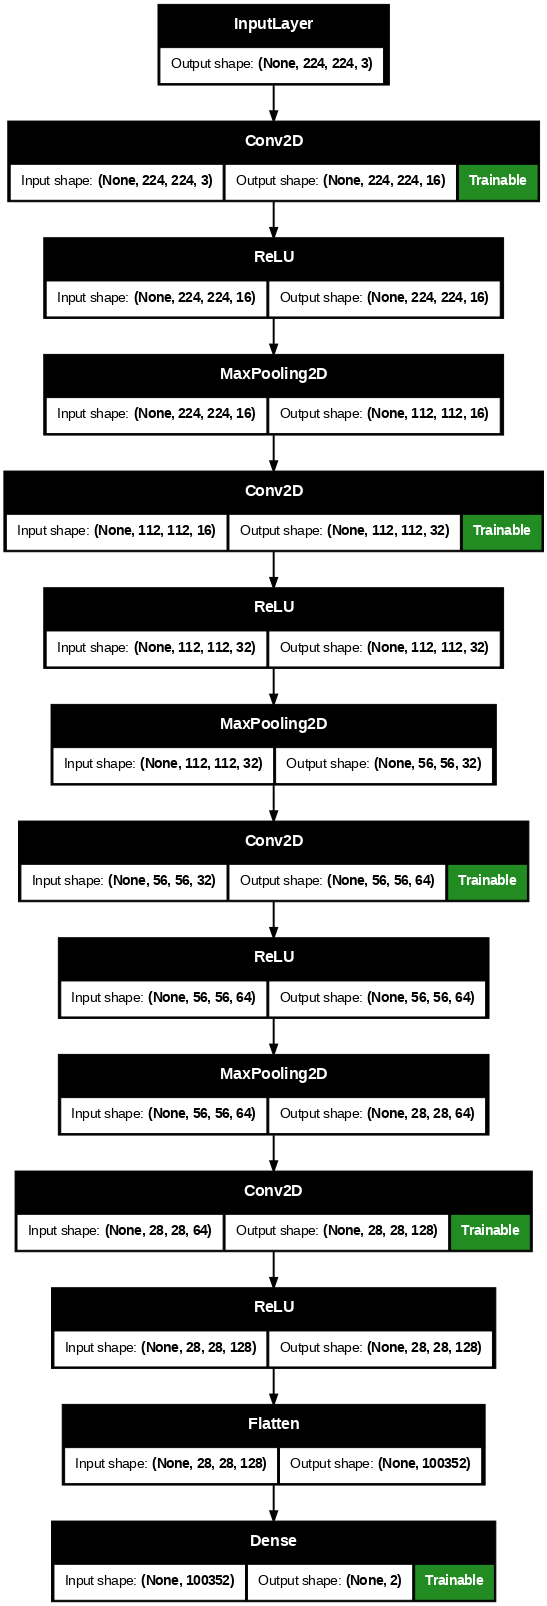

In [17]:
# Build the model with specified input and output shapes
model = build_model()

# Display a summary of the model architecture
model.summary(expand_nested=True, show_trainable=True)

# Plot the model architecture
tfk.utils.plot_model(model, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

## 🧠 Train the Model

In [18]:
# Define the patience value for early stopping
patience = 100

# Create an EarlyStopping callback
early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=patience,
    restore_best_weights=True
)

# Store the callback in a list
callbacks = [early_stopping]

In [19]:
# Train the model with early stopping callback
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=callbacks
).history

# Calculate and print the final validation accuracy
final_val_accuracy = round(max(history['val_accuracy'])* 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'CNN_'+str(final_val_accuracy)+'.keras'
model.save(model_filename)

# Delete the model to free up resources
del model

Epoch 1/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.4901 - loss: 0.7800 - val_accuracy: 0.5333 - val_loss: 0.6884
Epoch 2/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.6489 - loss: 0.6649 - val_accuracy: 0.5000 - val_loss: 0.6698
Epoch 3/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.6440 - loss: 0.6035 - val_accuracy: 0.5333 - val_loss: 0.6698
Epoch 4/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.6715 - loss: 0.5942 - val_accuracy: 0.6667 - val_loss: 0.5836
Epoch 5/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7402 - loss: 0.5089 - val_accuracy: 0.6333 - val_loss: 0.5986
Epoch 6/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.8209 - loss: 0.4431 - val_accuracy: 0.6667 - val_loss: 0.5611
Epoch 7/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.8630 - loss: 0.3303 - val_accuracy: 0.7333 - val_loss: 0.6120
Epoch 8/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8572 - loss: 0.3736 - val_accuracy: 0.7000 - va

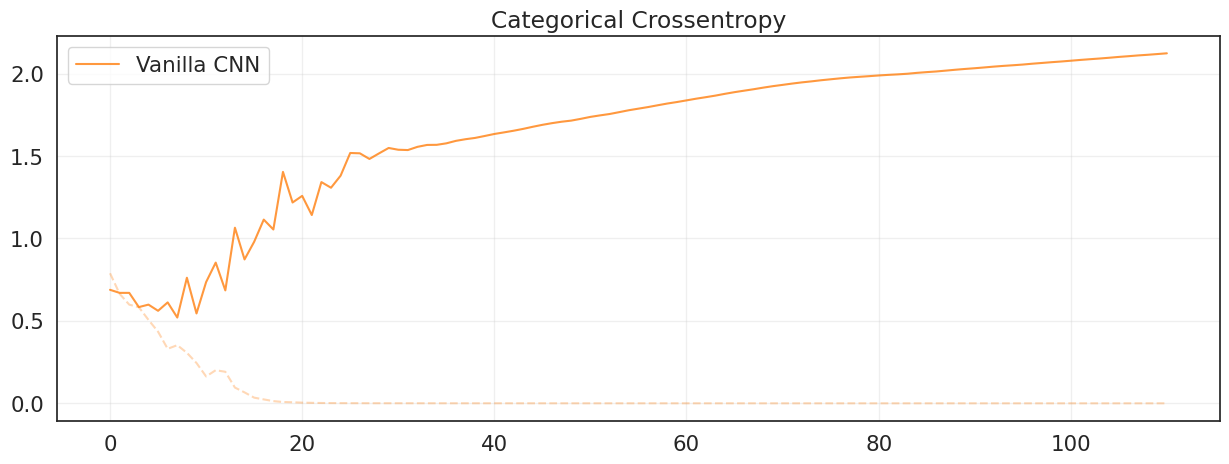

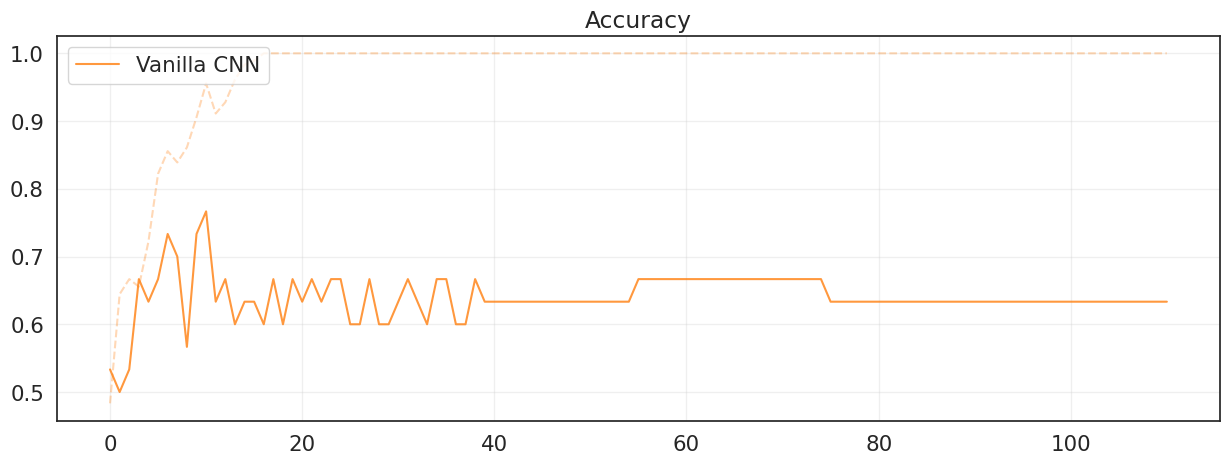

In [20]:
# Plot the training
plt.figure(figsize=(15,5))
plt.plot(history['loss'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_loss'], label='Vanilla CNN', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_accuracy'], label='Vanilla CNN', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

## 💪 Image Augmentaion

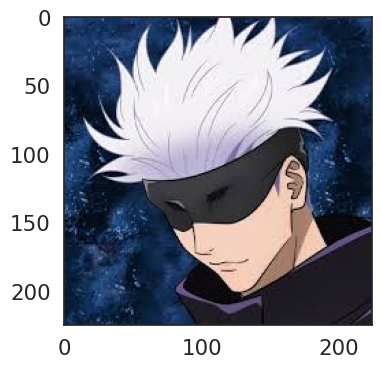

In [21]:
# Define the URL for the image
url = 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcStoEtY__xJfntgW3oCvg06vYkUZS24FTyoCQ&s'

# Send a GET request to the URL and retrieve the image content
response = requests.get(url)

# Load the image and normalise pixel values
img = np.array(Image.open(BytesIO(response.content))) / 255

# Display the image using matplotlib
plt.figure(figsize=(4,4))
plt.imshow(img)
plt.show()

#### Random Flip

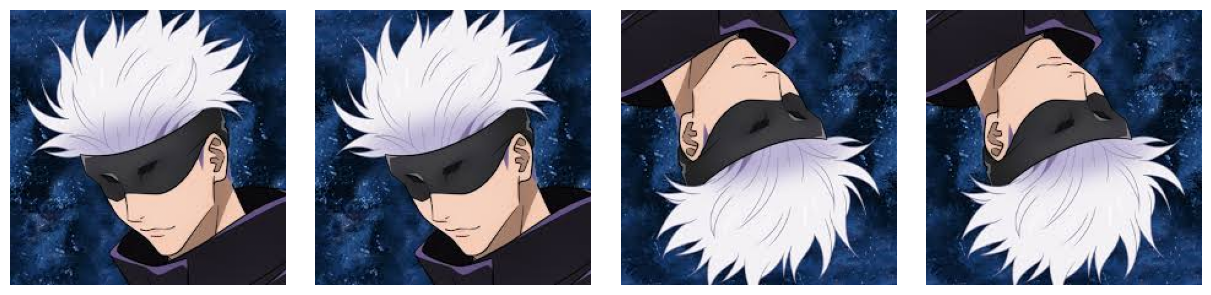

In [22]:
# Define a sequential model for image augmentation with random flipping
augmentation = tf.keras.Sequential([
    tfkl.RandomFlip("horizontal_and_vertical"),
])

# Set up the figure and grid layout for displaying images
fig = plt.figure(constrained_layout=True, figsize=(12, 3))
gs = gridspec.GridSpec(1, 4, figure=fig, width_ratios=[1, 1, 1, 1], wspace=0.1)

# Display the original image
ax1 = fig.add_subplot(gs[0])
ax1.imshow(np.squeeze(img))
ax1.axis('off')

# Apply augmentation and display the first augmented image
augmented_img = np.clip(augmentation(img), 0., 1.)
ax2 = fig.add_subplot(gs[1])
ax2.imshow(np.squeeze(augmented_img))
ax2.axis('off')

# Apply augmentation again and display the second augmented image
augmented_img = np.clip(augmentation(img), 0., 1.)
ax3 = fig.add_subplot(gs[2])
ax3.imshow(np.squeeze(augmented_img))
ax3.axis('off')

# Apply augmentation again and display the third augmented image
augmented_img = np.clip(augmentation(img), 0., 1.)
ax4 = fig.add_subplot(gs[3])
ax4.imshow(np.squeeze(augmented_img))
ax4.axis('off')

# Show the figure with all images
plt.show()

#### Random Translation

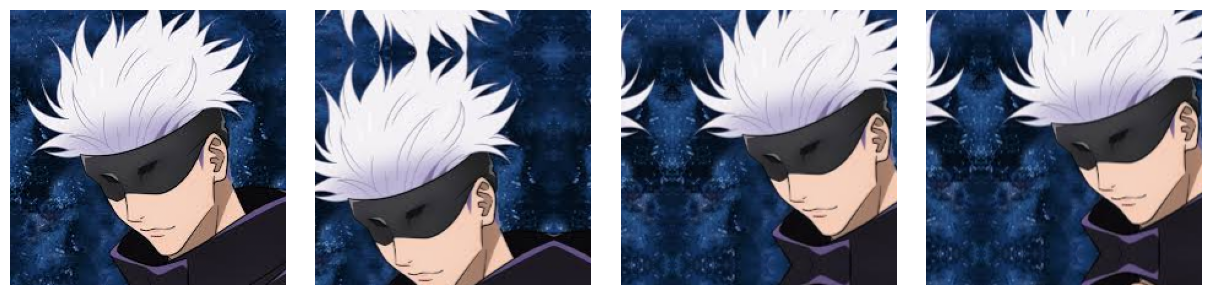

In [23]:
# Define a sequential model for image augmentation with random translation
augmentation = tf.keras.Sequential([
    tfkl.RandomTranslation(0.2,0.2),
])

# Set up the figure and grid layout for displaying images
fig = plt.figure(constrained_layout=True, figsize=(12, 3))
gs = gridspec.GridSpec(1, 4, figure=fig, width_ratios=[1, 1, 1, 1], wspace=0.1)

# Display the original image
ax1 = fig.add_subplot(gs[0])
ax1.imshow(np.squeeze(img))
ax1.axis('off')

# Apply augmentation and display the first augmented image
augmented_img = np.clip(augmentation(img), 0., 1.)
ax2 = fig.add_subplot(gs[1])
ax2.imshow(np.squeeze(augmented_img))
ax2.axis('off')

# Apply augmentation again and display the second augmented image
augmented_img = np.clip(augmentation(img), 0., 1.)
ax3 = fig.add_subplot(gs[2])
ax3.imshow(np.squeeze(augmented_img))
ax3.axis('off')

# Apply augmentation again and display the third augmented image
augmented_img = np.clip(augmentation(img), 0., 1.)
ax4 = fig.add_subplot(gs[3])
ax4.imshow(np.squeeze(augmented_img))
ax4.axis('off')

# Show the figure with all images
plt.show()

#### Random Rotation

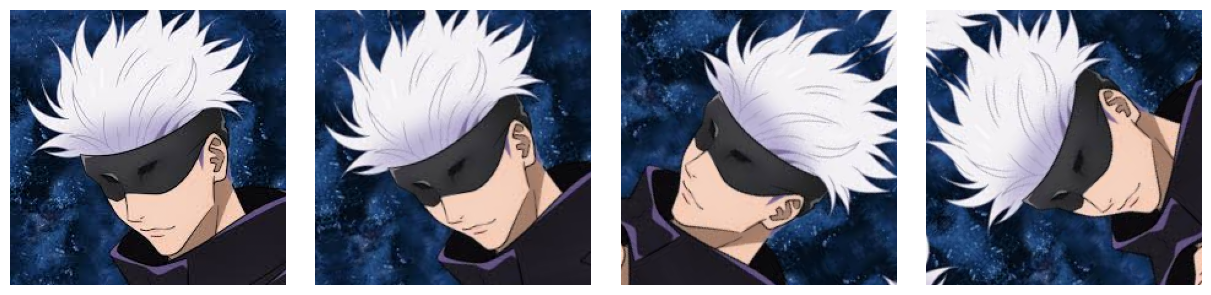

In [25]:
# Define a sequential model for image augmentation with random rotation
augmentation = tf.keras.Sequential([
    tfkl.RandomRotation(0.2),
])

# Set up the figure and grid layout for displaying images
fig = plt.figure(constrained_layout=True, figsize=(12, 3))
gs = gridspec.GridSpec(1, 4, figure=fig, width_ratios=[1, 1, 1, 1], wspace=0.1)

# Display the original image
ax1 = fig.add_subplot(gs[0])
ax1.imshow(np.squeeze(img))
ax1.axis('off')

# Apply augmentation and display the first augmented image
augmented_img = np.clip(augmentation(img), 0., 1.)
ax2 = fig.add_subplot(gs[1])
ax2.imshow(np.squeeze(augmented_img))
ax2.axis('off')

# Apply augmentation again and display the second augmented image
augmented_img = np.clip(augmentation(img), 0., 1.)
ax3 = fig.add_subplot(gs[2])
ax3.imshow(np.squeeze(augmented_img))
ax3.axis('off')

# Apply augmentation again and display the third augmented image
augmented_img = np.clip(augmentation(img), 0., 1.)
ax4 = fig.add_subplot(gs[3])
ax4.imshow(np.squeeze(augmented_img))
ax4.axis('off')

# Show the figure with all images
plt.show()

### Random Zoom

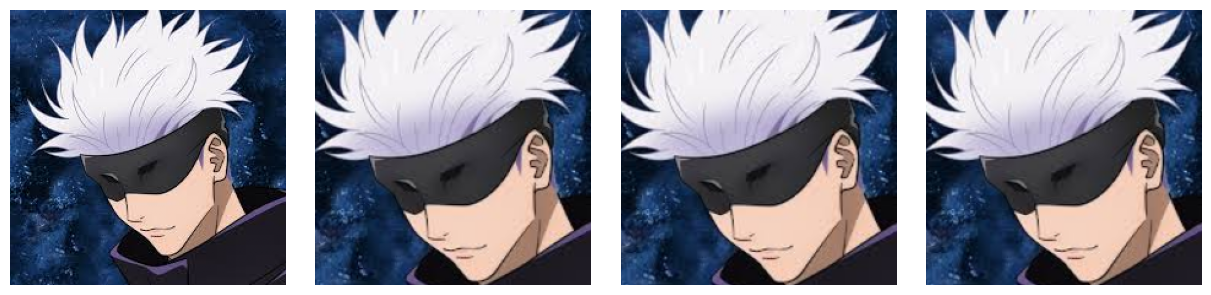

In [26]:
# Define a sequential model for image augmentation with random zoom
augmentation = tf.keras.Sequential([
    tfkl.RandomZoom(0.2),
])

# Set up the figure and grid layout for displaying images
fig = plt.figure(constrained_layout=True, figsize=(12, 3))
gs = gridspec.GridSpec(1, 4, figure=fig, width_ratios=[1, 1, 1, 1], wspace=0.1)

# Display the original image
ax1 = fig.add_subplot(gs[0])
ax1.imshow(np.squeeze(img))
ax1.axis('off')

# Apply augmentation and display the first augmented image
augmented_img = np.clip(augmentation(img), 0., 1.)
ax2 = fig.add_subplot(gs[1])
ax2.imshow(np.squeeze(augmented_img))
ax2.axis('off')

# Apply augmentation again and display the second augmented image
augmented_img = np.clip(augmentation(img), 0., 1.)
ax3 = fig.add_subplot(gs[2])
ax3.imshow(np.squeeze(augmented_img))
ax3.axis('off')

# Apply augmentation again and display the third augmented image
augmented_img = np.clip(augmentation(img), 0., 1.)
ax4 = fig.add_subplot(gs[3])
ax4.imshow(np.squeeze(augmented_img))
ax4.axis('off')

# Show the figure with all images
plt.show()

### Random Brightness

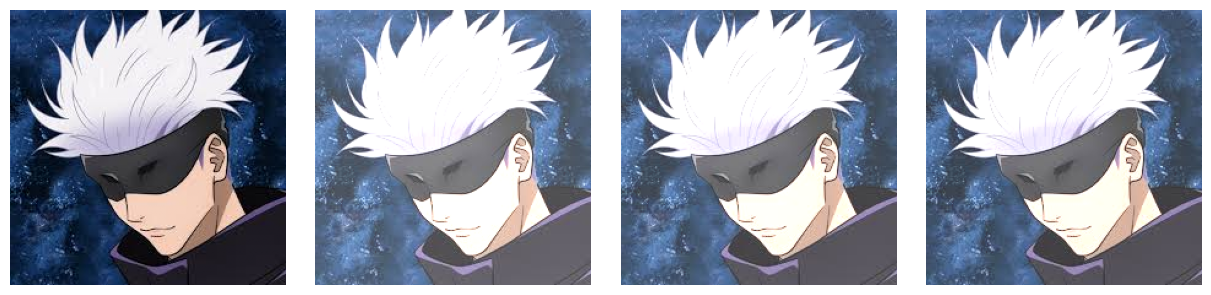

In [27]:
# Define a sequential model for image augmentation with random brightness
augmentation = tf.keras.Sequential([
    tfkl.RandomBrightness(0.5, value_range=(0,1)),
])

# Set up the figure and grid layout for displaying images
fig = plt.figure(constrained_layout=True, figsize=(12, 3))
gs = gridspec.GridSpec(1, 4, figure=fig, width_ratios=[1, 1, 1, 1], wspace=0.1)

# Display the original image
ax1 = fig.add_subplot(gs[0])
ax1.imshow(np.squeeze(img))
ax1.axis('off')

# Apply augmentation and display the first augmented image
augmented_img = np.clip(augmentation(img), 0., 1.)
ax2 = fig.add_subplot(gs[1])
ax2.imshow(np.squeeze(augmented_img))
ax2.axis('off')

# Apply augmentation again and display the second augmented image
augmented_img = np.clip(augmentation(img), 0., 1.)
ax3 = fig.add_subplot(gs[2])
ax3.imshow(np.squeeze(augmented_img))
ax3.axis('off')

# Apply augmentation again and display the third augmented image
augmented_img = np.clip(augmentation(img), 0., 1.)
ax4 = fig.add_subplot(gs[3])
ax4.imshow(np.squeeze(augmented_img))
ax4.axis('off')

# Show the figure with all images
plt.show()

### Random Contrast

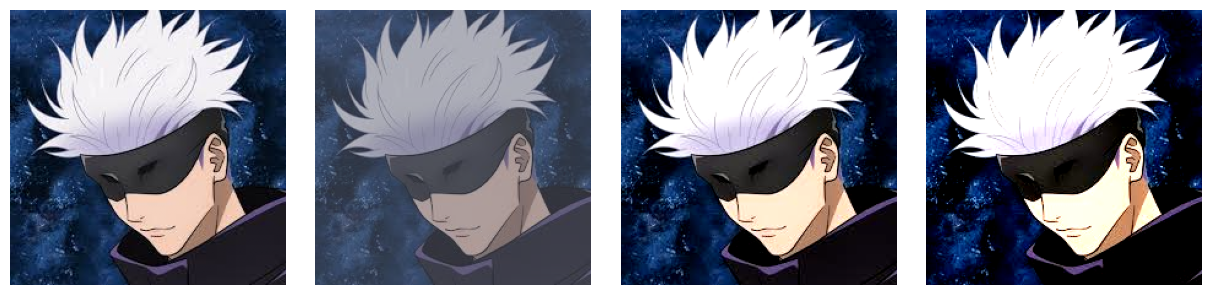

In [28]:
# Define a sequential model for image augmentation with random contrast
augmentation = tf.keras.Sequential([
    tfkl.RandomContrast(0.75),
])

# Set up the figure and grid layout for displaying images
fig = plt.figure(constrained_layout=True, figsize=(12, 3))
gs = gridspec.GridSpec(1, 4, figure=fig, width_ratios=[1, 1, 1, 1], wspace=0.1)

# Display the original image
ax1 = fig.add_subplot(gs[0])
ax1.imshow(np.squeeze(img))
ax1.axis('off')

# Apply augmentation and display the first augmented image
augmented_img = np.clip(augmentation(img), 0., 1.)
ax2 = fig.add_subplot(gs[1])
ax2.imshow(np.squeeze(augmented_img))
ax2.axis('off')

# Apply augmentation again and display the second augmented image
augmented_img = np.clip(augmentation(img), 0., 1.)
ax3 = fig.add_subplot(gs[2])
ax3.imshow(np.squeeze(augmented_img))
ax3.axis('off')

# Apply augmentation again and display the third augmented image
augmented_img = np.clip(augmentation(img), 0., 1.)
ax4 = fig.add_subplot(gs[3])
ax4.imshow(np.squeeze(augmented_img))
ax4.axis('off')

# Show the figure with all images
plt.show()

### All together

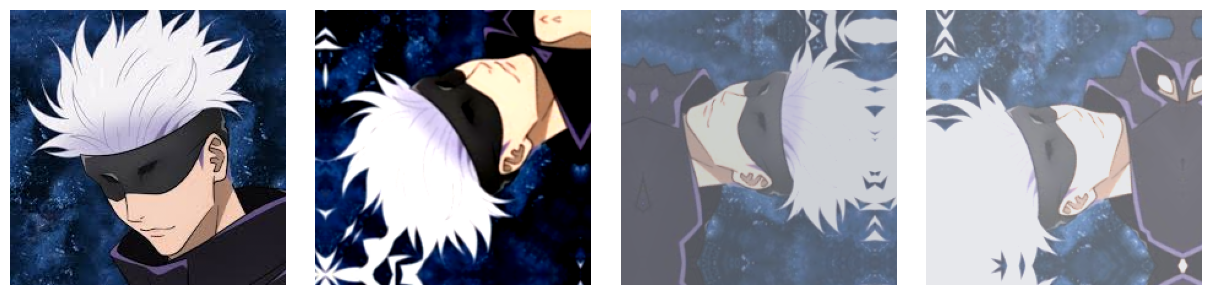

In [29]:
# Define a sequential model for image augmentation with various transformations
augmentation = tf.keras.Sequential([
    tfkl.RandomFlip("horizontal_and_vertical"),
    tfkl.RandomTranslation(0.2,0.2),
    tfkl.RandomRotation(0.2),
    tfkl.RandomZoom(0.2),
    tfkl.RandomBrightness(0.5, value_range=(0,1)),
    tfkl.RandomContrast(0.75),
], name='Augmentation')

# Set up the figure and grid layout for displaying images
fig = plt.figure(constrained_layout=True, figsize=(12, 3))
gs = gridspec.GridSpec(1, 4, figure=fig, width_ratios=[1, 1, 1, 1], wspace=0.1)

# Display the original image
ax1 = fig.add_subplot(gs[0])
ax1.imshow(np.squeeze(img))
ax1.axis('off')

# Apply augmentation and display the first augmented image
augmented_img = np.clip(augmentation(img), 0., 1.)
ax2 = fig.add_subplot(gs[1])
ax2.imshow(np.squeeze(augmented_img))
ax2.axis('off')

# Apply augmentation again and display the second augmented image
augmented_img = np.clip(augmentation(img), 0., 1.)
ax3 = fig.add_subplot(gs[2])
ax3.imshow(np.squeeze(augmented_img))
ax3.axis('off')

# Apply augmentation again and display the third augmented image
augmented_img = np.clip(augmentation(img), 0., 1.)
ax4 = fig.add_subplot(gs[3])
ax4.imshow(np.squeeze(augmented_img))
ax4.axis('off')

# Show the figure with all images
plt.show()

## 🛠️ Build the Model

Model: "CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)                        ┃ Output Shape                 ┃       Param # ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ Input (InputLayer)                  │ (None, 224, 224, 3)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ preprocessing (Sequential)          │ (None, 224, 224, 3)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ random_flip_3 (RandomFlip)     │ (None, 224, 224, 3)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ random_brightness_3            │ (None, 224, 224, 3)          │             0 │    -    │
│ (RandomBrightness)                  │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ random_translation_3           │ (None, 224, 224, 3)          │             0 │    -    │
│ (RandomTranslation)                 │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv0 (Conv2D)                      │ (None, 224, 224, 16)         │           448 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ relu0 (ReLU)                        │ (None, 224, 224, 16)         │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ mp0 (MaxPooling2D)                  │ (None, 112, 112, 16)         │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv1 (Conv2D)                      │ (None, 112, 112, 32)         │         4,640 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ relu1 (ReLU)                        │ (None, 112, 112, 32)         │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ mp1 (MaxPooling2D)                  │ (None, 56, 56, 32)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv2 (Conv2D)                      │ (None, 56, 56, 64)           │        18,496 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ relu2 (ReLU)                        │ (None, 56, 56, 64)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ mp2 (MaxPooling2D)                  │ (None, 28, 28, 64)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv3 (Conv2D)                      │ (None, 28, 28, 128)          │        73,856 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ relu3 (ReLU)                        │ (None, 28, 28, 128)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ flatten (Flatten)                   │ (None, 100352)               │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ Output (Dense)                      │ (None, 2)                    │       200,706 │    Y    │
└─────────────────────────────────────┴──────────────────────────────┴───────────────┴─────────┘

 Total params: 298,146 (1.14 MB)

 Trainable params: 298,146 (1.14 MB)

 Non-trainable params: 0 (0.00 B)

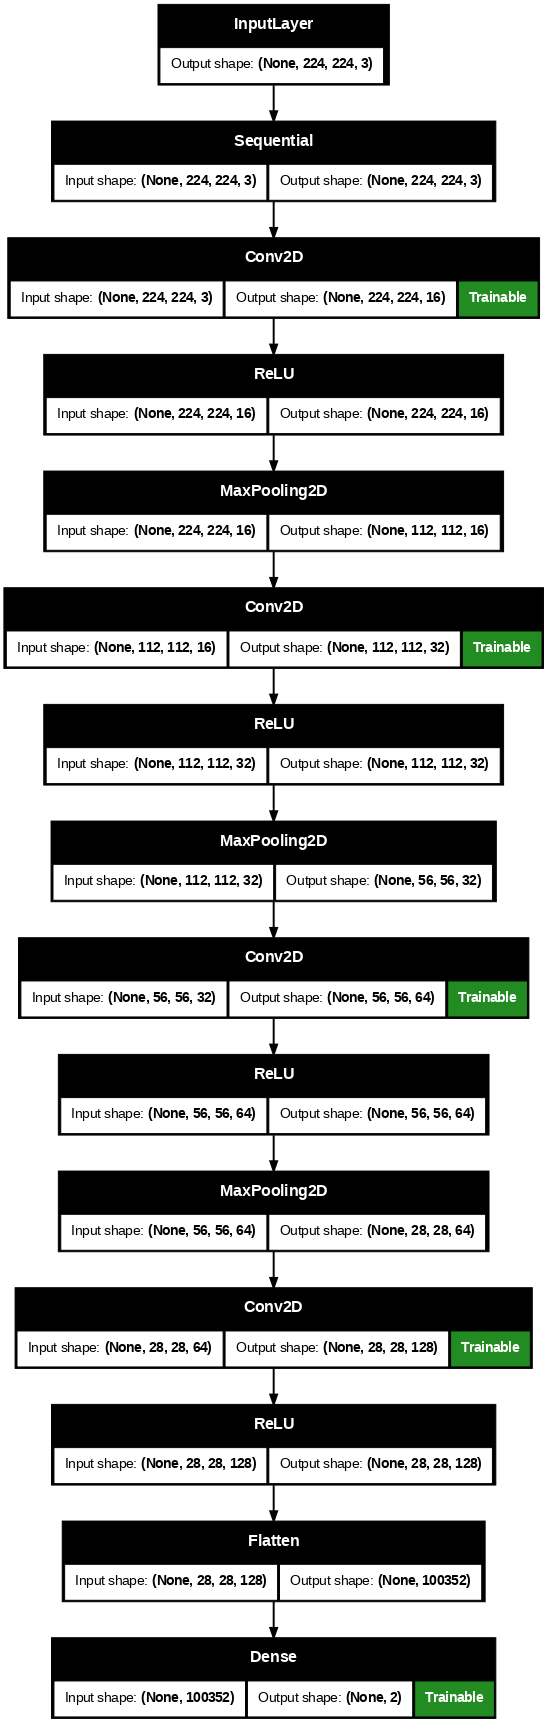

In [37]:
# Define a data augmentation pipeline with random flip, brightness, and translation
augmentation = tf.keras.Sequential([
    tfkl.RandomFlip("horizontal"),
    tfkl.RandomBrightness(0.2, value_range=(0,1)),
    tfkl.RandomTranslation(0.2,0.2),
], name='preprocessing')

# Build the model with specified input and output shapes
model = build_model(augmentation=augmentation)

# Display a summary of the model architecture
model.summary(expand_nested=True, show_trainable=True)

# Plot the model architecture
tfk.utils.plot_model(model, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

## 🧠 Train the Model

In [38]:
# Define the patience value for early stopping
patience = 100

# Create an EarlyStopping callback
early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=patience,
    restore_best_weights=True
)

# Store the callback in a list
callbacks = [early_stopping]

In [39]:
# Train the model with early stopping callback
aug_history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=callbacks
).history

# Calculate and print the final validation accuracy
final_val_accuracy = round(max(aug_history['val_accuracy'])* 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'AugCNN_'+str(final_val_accuracy)+'.keras'
model.save(model_filename)

# Delete the model to free up resources
del model

Epoch 1/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - accuracy: 0.5068 - loss: 0.7645 - val_accuracy: 0.4667 - val_loss: 0.6932
Epoch 2/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.5528 - loss: 0.6800 - val_accuracy: 0.5000 - val_loss: 0.6722
Epoch 3/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6358 - loss: 0.6474 - val_accuracy: 0.6000 - val_loss: 0.6482
Epoch 4/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.5916 - loss: 0.6950 - val_accuracy: 0.6667 - val_loss: 0.6251
Epoch 5/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6802 - loss: 0.6256 - val_accuracy: 0.5667 - val_loss: 0.6884
Epoch 6/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.6407 - loss: 0.6554 - val_accuracy: 0.6000 - val_loss: 0.6537
Epoch 7/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.7167 - loss: 0.6065 - val_accuracy: 0.5667 - val_loss: 0.7150
Epoch 8/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.6685 - loss: 0.5717 - val_accuracy: 0.6000 - 

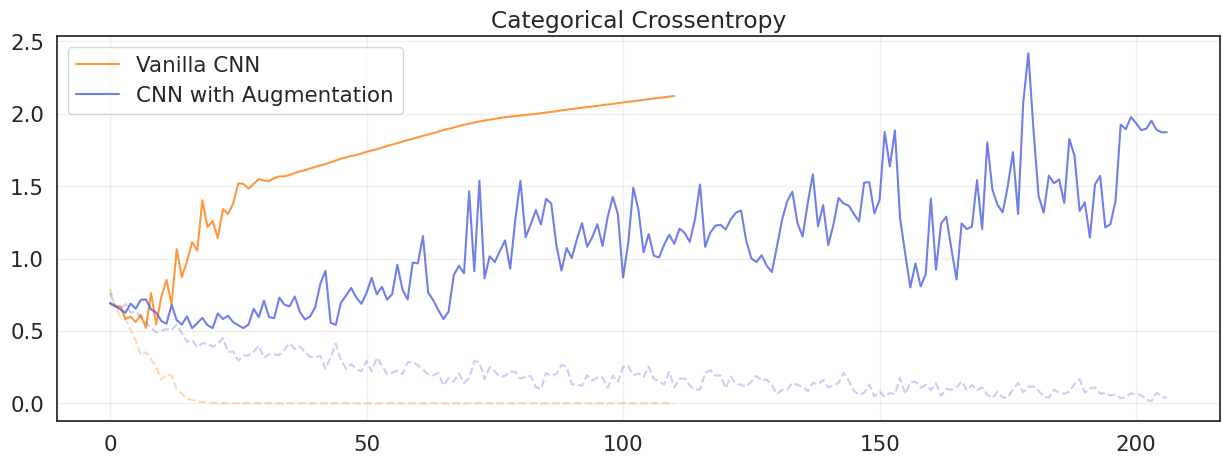

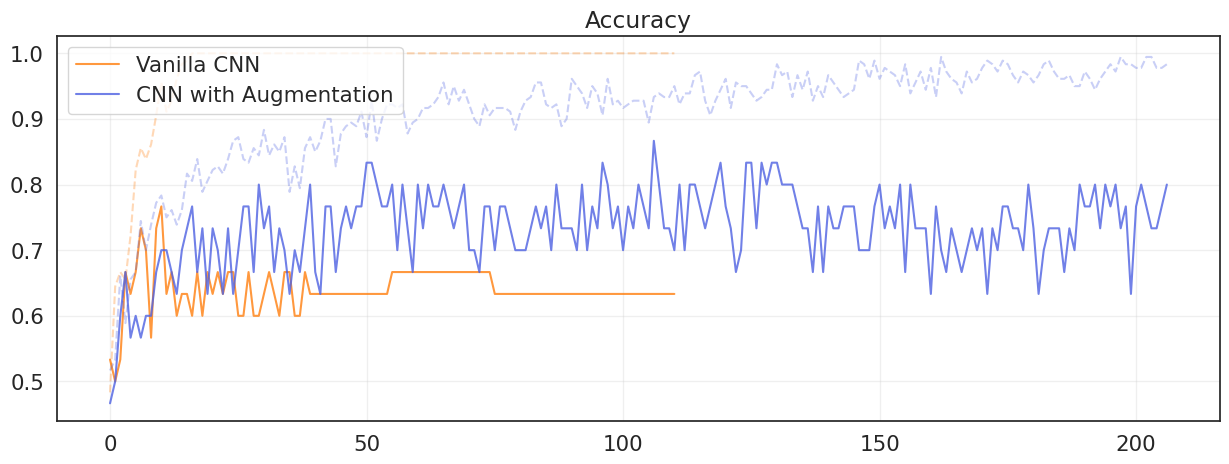

In [40]:
# Plot the training
plt.figure(figsize=(15,5))
plt.plot(history['loss'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_loss'], label='Vanilla CNN', alpha=.8, color='#ff7f0e')
plt.plot(aug_history['loss'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(aug_history['val_loss'], label='CNN with Augmentation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_accuracy'], label='Vanilla CNN', alpha=.8, color='#ff7f0e')
plt.plot(aug_history['accuracy'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(aug_history['val_accuracy'], label='CNN with Augmentation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

## 🕹️ Use the Model - Make Inference

In [43]:
# Load the saved model
model = tfk.models.load_model('AugCNN_86.67.keras')

# Display a summary of the model architecture
model.summary(expand_nested=True, show_trainable=True)

Model: "CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)                        ┃ Output Shape                 ┃       Param # ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ Input (InputLayer)                  │ (None, 224, 224, 3)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ preprocessing (Sequential)          │ (None, 224, 224, 3)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ random_flip_3 (RandomFlip)     │ (None, 224, 224, 3)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ random_brightness_3            │ (None, 224, 224, 3)          │             0 │    -    │
│ (RandomBrightness)                  │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ random_translation_3           │ (None, 224, 224, 3)          │             0 │    -    │
│ (RandomTranslation)                 │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv0 (Conv2D)                      │ (None, 224, 224, 16)         │           448 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ relu0 (ReLU)                        │ (None, 224, 224, 16)         │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ mp0 (MaxPooling2D)                  │ (None, 112, 112, 16)         │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv1 (Conv2D)                      │ (None, 112, 112, 32)         │         4,640 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ relu1 (ReLU)                        │ (None, 112, 112, 32)         │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ mp1 (MaxPooling2D)                  │ (None, 56, 56, 32)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv2 (Conv2D)                      │ (None, 56, 56, 64)           │        18,496 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ relu2 (ReLU)                        │ (None, 56, 56, 64)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ mp2 (MaxPooling2D)                  │ (None, 28, 28, 64)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv3 (Conv2D)                      │ (None, 28, 28, 128)          │        73,856 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ relu3 (ReLU)                        │ (None, 28, 28, 128)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ flatten (Flatten)                   │ (None, 100352)               │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ Output (Dense)                      │ (None, 2)                    │       200,706 │    Y    │
└─────────────────────────────────────┴──────────────────────────────┴───────────────┴─────────┘

 Total params: 894,440 (3.41 MB)

 Trainable params: 298,146 (1.14 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 596,294 (2.27 MB)

Accuracy score over the test set: 0.8
Precision score over the test set: 0.8
Recall score over the test set: 0.8
F1 score over the test set: 0.8


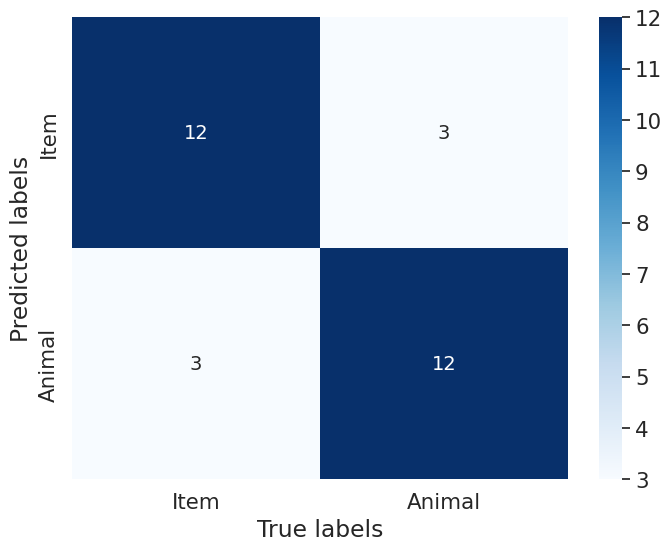

In [44]:
# Predict class probabilities and get predicted classes
test_predictions = model.predict(X_test, verbose=0)
test_predictions = np.argmax(test_predictions, axis=-1)

# Extract ground truth classes
test_gt = np.argmax(y_test, axis=-1)

# Calculate and display test set accuracy
test_accuracy = accuracy_score(test_gt, test_predictions)
print(f'Accuracy score over the test set: {round(test_accuracy, 4)}')

# Calculate and display test set precision
test_precision = precision_score(test_gt, test_predictions, average='weighted')
print(f'Precision score over the test set: {round(test_precision, 4)}')

# Calculate and display test set recall
test_recall = recall_score(test_gt, test_predictions, average='weighted')
print(f'Recall score over the test set: {round(test_recall, 4)}')

# Calculate and display test set F1 score
test_f1 = f1_score(test_gt, test_predictions, average='weighted')
print(f'F1 score over the test set: {round(test_f1, 4)}')

# Compute the confusion matrix
cm = confusion_matrix(test_gt, test_predictions)

# Create labels combining confusion matrix values
labels = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

# Plot the confusion matrix with class labels
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=labels, fmt='', xticklabels=['Item','Animal'], yticklabels=['Item','Animal'], cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

## 🪄 Image Retrieval

In [45]:
# Create an embedding model by removing the last layer of the original model
embedding = tfk.Sequential(model.layers[:-1])

# Display the summary of the embedding model architecture
embedding.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ preprocessing (Sequential)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv0 (Conv2D)                       │ (None, 224, 224, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ relu0 (ReLU)                         │ (None, 224, 224, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mp0 (MaxPooling2D)                   │ (None, 112, 112, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 112, 112, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ relu1 (ReLU)                         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mp1 (MaxPooling2D)                   │ (None, 56, 56, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2 (Conv2D)                       │ (None, 56, 56, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ relu2 (ReLU)                         │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mp2 (MaxPooling2D)                   │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3 (Conv2D)                       │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ relu3 (ReLU)                         │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 100352)              │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 97,440 (380.62 KB)

 Trainable params: 97,440 (380.62 KB)

 Non-trainable params: 0 (0.00 B)

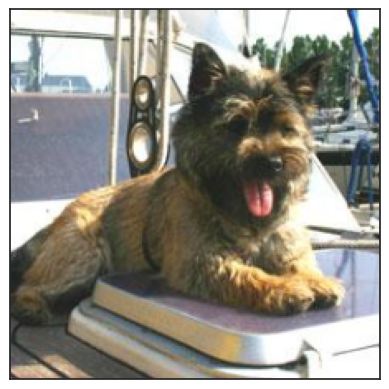

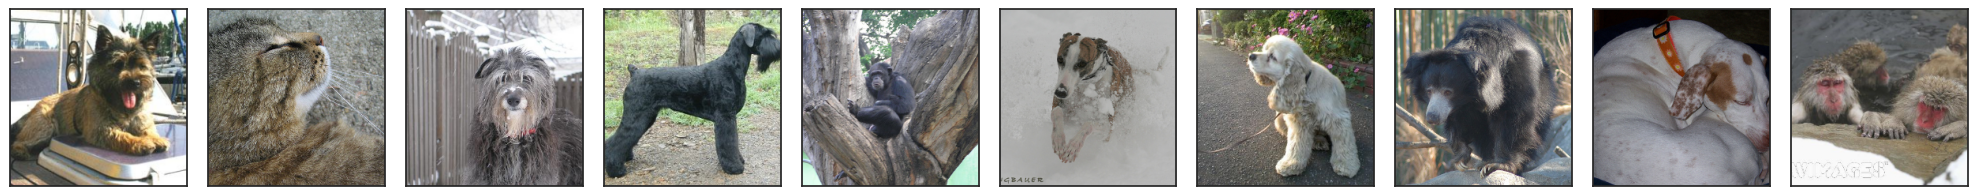

In [47]:
# Extract and preprocess a single image for feature extraction
index = 100
image = np.expand_dims(X[index], axis=0)

# Predict the features of the selected image using the embedding model
image_features = embedding.predict(image, verbose=0)

# Display the selected image
plt.imshow(X[index])
plt.xticks([])
plt.yticks([])
plt.show()

# Extract features from the entire dataset using the embedding model
dataset_features = embedding.predict(X, batch_size=32, verbose=0)

# Compute the distances between the selected image's features and the entire dataset's features
distances = np.mean(np.square(dataset_features - image_features), axis=-1)

# Sort images by their distances (similarity to the selected image)
ordered_images = X[distances.argsort()]

# Display the top 10 most similar images
num_img = 10
fig, axes = plt.subplots(1, num_img, figsize=(20, 20))
for i in range(num_img):
    ax = axes[i % num_img]
    ax.imshow(ordered_images[i])
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
plt.show()

#### Use Pretrained Models as Image Search Engine

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)           ┃ Output Shape         ┃      Param # ┃ Connected to        ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer_10         │ (None, 224, 224, 3)  │            0 │ -                   │    -    │
│ (InputLayer)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ Conv1 (Conv2D)         │ (None, 112, 112, 32) │          864 │ input_layer_10[0][… │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ bn_Conv1               │ (None, 112, 112, 32) │          128 │ Conv1[0][0]         │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ Conv1_relu (ReLU)      │ (None, 112, 112, 32) │            0 │ bn_Conv1[0][0]      │    -    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ expanded_conv_depthwi… │ (None, 112, 112, 32) │          288 │ Conv1_relu[0][0]    │    Y    │
│ (DepthwiseConv2D)      │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ expanded_conv_depthwi… │ (None, 112, 112, 32) │          128 │ expanded_conv_dept… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ expanded_conv_depthwi… │ (None, 112, 112, 32) │            0 │ expanded_conv_dept… │    -    │
│ (ReLU)                 │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ expanded_conv_project  │ (None, 112, 112, 16) │          512 │ expanded_conv_dept… │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ expanded_conv_project… │ (None, 112, 112, 16) │           64 │ expanded_conv_proj… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ block_1_expand         │ (None, 112, 112, 96) │        1,536 │ expanded_conv_proj… │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ block_1_expand_BN      │ (None, 112, 112, 96) │          384 │ block_1_expand[0][… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ block_1_expand_relu    │ (None, 112, 112, 96) │            0 │ block_1_expand_BN[… │    -    │
│ (ReLU)                 │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ block_1_pad            │ (None, 113, 113, 96) │            0 │ block_1_expand_rel… │    -    │
│ (ZeroPadding2D)        │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ block_1_depthwise      │ (None, 56, 56, 96)   │          864 │ block_1_pad[0][0]   │    Y    │
│ (DepthwiseConv2D)    

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,223,872 (8.48 MB)

 Non-trainable params: 34,112 (133.25 KB)

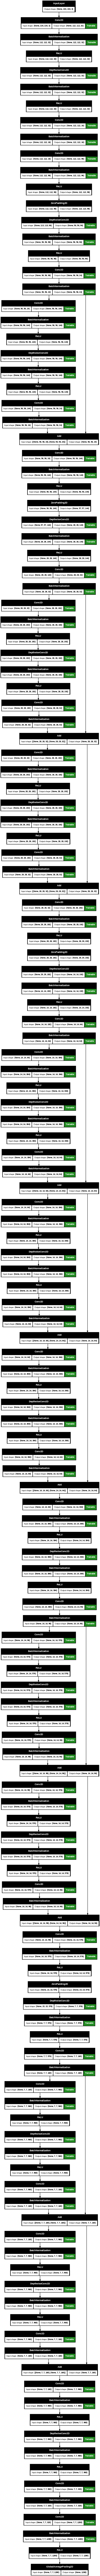

In [48]:
# Load the MobileNetV2 model pre-trained on ImageNet, without the top classification layer
mobilenet = tfk.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights="imagenet",
    pooling='avg',
)

# Display a summary of the model architecture
mobilenet.summary(expand_nested=True, show_trainable=True)

# Plot the model architecture
tfk.utils.plot_model(mobilenet, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

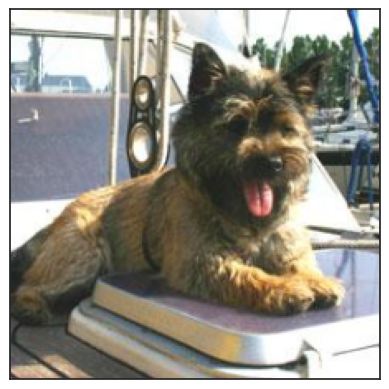

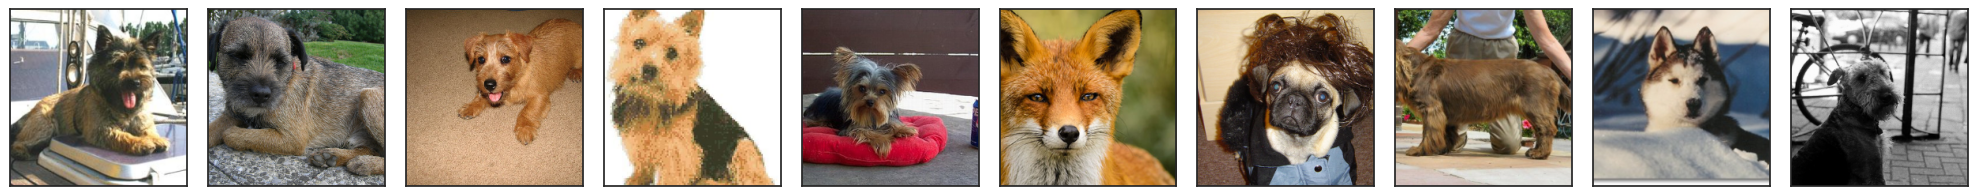

In [49]:
# Extract and preprocess a single image for feature extraction using MobileNetV2
index = 100
image = np.expand_dims(X[index], axis=0)

# Preprocess the image and predict its features using the MobileNetV2 model
image_features = mobilenet.predict(preprocess_input(image * 255), verbose=0)

# Display the selected image
plt.imshow(X[index])
plt.xticks([])
plt.yticks([])
plt.show()

# Preprocess the dataset and extract features from all images using MobileNetV2
dataset_features = mobilenet.predict(preprocess_input(X * 255), batch_size=32, verbose=0)

# Compute the distances between the selected image's features and the entire dataset's features
distances = np.mean(np.square(dataset_features - image_features), axis=-1)

# Sort images by their distances (similarity to the selected image)
ordered_images = X[distances.argsort()]

# Display the top 10 most similar images
num_img = 10
fig, axes = plt.subplots(1, num_img, figsize=(20, 20))
for i in range(num_img):
    ax = axes[i % num_img]
    ax.imshow(ordered_images[i])
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
plt.show()